In [ ]:
# this code crop the whole image according to bound boxes

import os
import xml.etree.ElementTree as ET
from PIL import Image


IMAGE_PATH = "/content/drive/MyDrive/Zain/data/input/67.jpg"
XML_PATH = "/content/drive/MyDrive/Zain/data/input/67.xml"
OUTPUT_DIR = "/content/drive/MyDrive/Zain/data/output/cropped_spots"


image = Image.open(IMAGE_PATH)



tree = ET.parse(XML_PATH)
root = tree.getroot()


parking_spots = root.findall(".//polygon")


os.makedirs(OUTPUT_DIR, exist_ok=True)


for i, spot in enumerate(parking_spots):
    points_str = spot.attrib["points"]
    points = [tuple(map(float, p.split(","))) for p in points_str.split(";")]


    x_coords, y_coords = zip(*points)
    x_min, y_min = int(min(x_coords)), int(min(y_coords))
    x_max, y_max = int(max(x_coords)), int(max(y_coords))


    cropped = image.crop((x_min, y_min, x_max, y_max))
    cropped.save(f"{OUTPUT_DIR}/spot_{i+1}.png")

print(f"Cropped {len(parking_spots)} spots saved to {OUTPUT_DIR}/")


Cropped 3 spots saved to /content/drive/MyDrive/Zain/project/output/cropped_spots/


In [ ]:
import os
import shutil
import random

# Paths
base_dir = "/content/drive/MyDrive/Zain/data/input/parking_classifier_data"
train_dir = os.path.join(base_dir, "Train")
val_dir = os.path.join(base_dir, "val")

classes = ['occupied', 'empty']
split_ratio = 0.8  # 80% train, 20% val

# Step 1: Create directories
for split_dir in [train_dir, val_dir]:
    for cls in classes:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

# Step 2: Collect and classify images
all_images = [f for f in os.listdir(base_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

occupied_images = [f for f in all_images if 'occupied' in f.lower()]
empty_images = [f for f in all_images if 'empty' in f.lower()]

# Helper function
def split_and_move(images, class_name):
    random.shuffle(images)
    split_index = int(len(images) * split_ratio)
    train_images = images[:split_index]
    val_images = images[split_index:]

    for img in train_images:
        shutil.move(os.path.join(base_dir, img), os.path.join(train_dir, class_name, img))

    for img in val_images:
        shutil.move(os.path.join(base_dir, img), os.path.join(val_dir, class_name, img))

# Step 3: Split and move
split_and_move(occupied_images, "occupied")
split_and_move(empty_images, "empty")

print("✅ Dataset split into Train and val with class folders.")


✅ Dataset split into Train and val with class folders.


In [ ]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models

# Parameters
BATCH_SIZE =5
EPOCHS = 10
LR = 0.0001  # Reduced LR
WEIGHT_DECAY = 1e-5
DATA_DIR = "/content/drive/MyDrive/Zain/data/input/parking_classifier_data"
MODEL_PATH = "/content/drive/MyDrive/Zain/data/classifier_model/parking_classifier.pth"
os.makedirs("classifier_model", exist_ok=True)


train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "Train"), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 2)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f} ")

# Saving the model
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 137.0135 
Epoch 2/10, Loss: 72.5251 
Epoch 3/10, Loss: 43.7984 
Epoch 4/10, Loss: 35.6391 
Epoch 5/10, Loss: 27.2328 
Epoch 6/10, Loss: 21.8499 
Epoch 7/10, Loss: 27.4177 
Epoch 8/10, Loss: 28.0725 
Epoch 9/10, Loss: 15.7749 
Epoch 10/10, Loss: 12.8200 
Model saved to /content/drive/MyDrive/Zain/project/classifier_model/parking_classifier.pth


Validation Accuracy: 0.9115
Classification Report:
               precision    recall  f1-score   support

       empty       0.91      0.80      0.85       123
    occupied       0.91      0.96      0.94       261

    accuracy                           0.91       384
   macro avg       0.91      0.88      0.90       384
weighted avg       0.91      0.91      0.91       384



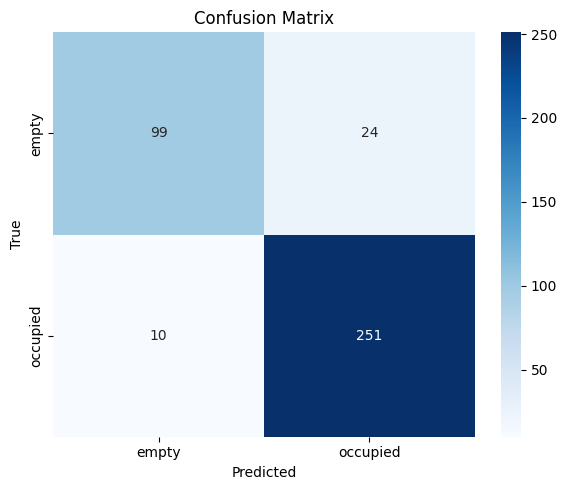

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Evaluation ===
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=val_dataset.classes)
cm = confusion_matrix(all_labels, all_preds)
class_names = val_dataset.classes

print(f"Validation Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
all_labels

[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(1)]

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# Load class names
class_names = ["Empty", "Occupied"]  # Order must match your training dataset folders

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model = models.resnet18(pretrained=False)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 2)
)
model.load_state_dict(torch.load("/content/drive/MyDrive/Zain/data/classifier_model/parking_classifier.pth", map_location=device))
model = model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Prediction: empty


In [ ]:
import xml.etree.ElementTree as ET

XML_ANNOTATION_PATH = "/content/drive/MyDrive/Zain/data/input/44.xml"  # Update with your actual path

def parse_parking_spots_from_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    spots = []
    count = 1
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        width = xmax - xmin
        height = ymax - ymin
        spots.append({
            "id": count,
            "coords": [xmin, ymin, width, height]
        })
        count += 1
    return spots

parking_spots = parse_parking_spots_from_xml(XML_ANNOTATION_PATH)


In [ ]:

# data augmentation
import os
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# === CONFIGURATION ===
DATA_DIR = "/content/drive/MyDrive/Zain/data/input/parking_classifier_data"
INPUT_TRAIN_DIR = os.path.join(DATA_DIR, "AugmentedTrain")
INPUT_VAL_DIR = os.path.join(DATA_DIR, "Augmentedval")
AUG_TRAIN_DIR = os.path.join(DATA_DIR, "Train")
AUG_VAL_DIR = os.path.join(DATA_DIR, "val")
NUM_AUG_TRAIN = 5
NUM_AUG_VAL = 2
IMAGE_SIZE = (64, 64)

# === AUGMENTATION TRANSFORMS ===
augment_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
])

resize_transform = transforms.Resize(IMAGE_SIZE)

# === FUNCTION TO PROCESS AND SAVE AUGMENTED IMAGES ===
def augment_and_save_images(source_dir, target_dir, num_augments):
    if not os.path.exists(source_dir):
        print(f"❌ Source directory does not exist: {source_dir}")
        return

    os.makedirs(target_dir, exist_ok=True)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        target_class_path = os.path.join(target_dir, class_name)
        os.makedirs(target_class_path, exist_ok=True)

        for img_name in tqdm(os.listdir(class_path), desc=f"Augmenting {class_name}"):
            img_path = os.path.join(class_path, img_name)
            try:
                image = Image.open(img_path).convert("RGB")
            except Exception as e:
                print(f"⚠️ Skipping {img_name}: {e}")
                continue

            base_name = os.path.splitext(img_name)[0]

            # Save resized original
            resized_image = resize_transform(image)
            resized_image.save(os.path.join(target_class_path, f"{base_name}_orig.jpg"))

            # Save augmentations
            for i in range(num_augments):
                augmented_image = augment_transform(image)
                aug_name = f"{base_name}_aug{i}.jpg"
                augmented_image.save(os.path.join(target_class_path, aug_name))

# === RUN AUGMENTATION FOR TRAIN AND VAL ===
augment_and_save_images(INPUT_TRAIN_DIR, AUG_TRAIN_DIR, NUM_AUG_TRAIN)
augment_and_save_images(INPUT_VAL_DIR, AUG_VAL_DIR, NUM_AUG_VAL)


Augmenting occupied: 100%|██████████| 19/19 [00:01<00:00, 18.36it/s]


In [ ]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models

# Parameters
BATCH_SIZE = 5
EPOCHS = 10  # Reduced for fine-tuning
LR = 1e-5   # Lower LR for fine-tuning
WEIGHT_DECAY = 1e-5
DATA_DIR = "/content/drive/MyDrive/Zain/data/input/parking_classifier_data"
MODEL_PATH = "/content/drive/MyDrive/Zain/data/classifier_model/parking_classifier.pth"
FINETUNED_MODEL_PATH = "/content/drive/MyDrive/Zain/data/classifier_model/parking_classifier_finetuned.pth"

# Ensure model folder exists
os.makedirs(os.path.dirname(FINETUNED_MODEL_PATH), exist_ok=True)

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Datasets and DataLoaders
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "Train"), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load model and modify classifier
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 2)
)

# Load pretrained weights if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    print(f"Loaded pretrained model from: {MODEL_PATH}")
model = model.to(device)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only layer4 and fc layers
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

# Fine-tuning loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}")

# Save fine-tuned model
torch.save(model.state_dict(), FINETUNED_MODEL_PATH)
print(f"Fine-tuned model saved to {FINETUNED_MODEL_PATH}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded pretrained model from: /content/drive/MyDrive/Zain/project/classifier_model/parking_classifier.pth
Epoch 1/10, Loss: 17.6132
Epoch 2/10, Loss: 25.5361
Epoch 3/10, Loss: 13.8515
Epoch 4/10, Loss: 10.3459
Epoch 5/10, Loss: 13.7465
Epoch 6/10, Loss: 5.0817
Epoch 7/10, Loss: 3.9342
Epoch 8/10, Loss: 11.7226
Epoch 9/10, Loss: 2.8630
Epoch 10/10, Loss: 1.8290
Fine-tuned model saved to /content/drive/MyDrive/Zain/project/classifier_model/parking_classifier_finetuned.pth


Validation Accuracy: 0.9310
Classification Report:
               precision    recall  f1-score   support

       empty       0.92      0.90      0.91       159
    occupied       0.94      0.95      0.94       261

    accuracy                           0.93       420
   macro avg       0.93      0.92      0.93       420
weighted avg       0.93      0.93      0.93       420



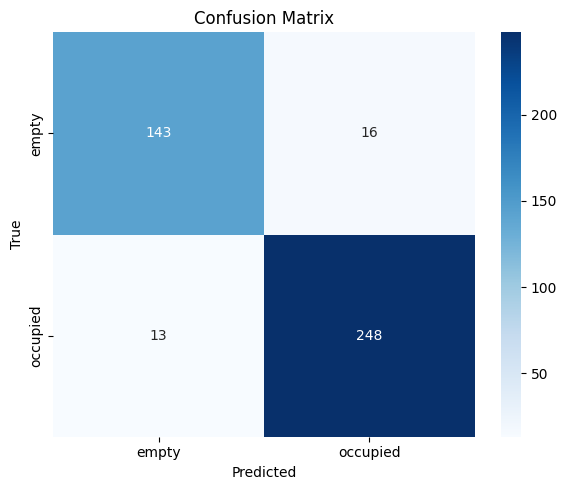

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Evaluation ===
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=val_dataset.classes)
cm = confusion_matrix(all_labels, all_preds)
class_names = val_dataset.classes

print(f"Validation Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
